# Updated accuracy

The previous accuracy requirements were based on an estimate of the scaling of $\Delta\Sigma$ with mass, but at a scale that we were not measuring in this project. Therefore, we will take a different approach and plot a different quantity: the mass at a given redshift for which the emulator will have reached 1% accuracy in mass. So, we can compute the required precision as
$$
\frac{\sigma_b}{b} = \frac{M}{b}\frac{{\rm d}b}{{\rm d}M}\frac{\sigma_M}{M}\,.
$$
where $\sigma_M/M = 0.01$.

In [1]:
import numpy as np
import bias_emulator
from classy import Class #for k and P(k)
import cluster_toolkit as ct
import matplotlib.pyplot as plt
from scipy import optimize as op
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [3]:
accuracy_model = bias_emulator.accuracy_model.bias_accuracy() #this yields the accuracy of the emulator

In [4]:
#Define areas, source densities, and zstars for different surveys
names = ["DES Y1", "DES Y5", "LSST Y1"]

In [5]:
Omega_b = 0.05
Omega_m = 0.3
Omega_cdm = Omega_m - Omega_b
h = 0.7
params = {
        'output': 'mPk',
        "h":h,
        "A_s":1.9735e-9, #Yields sigma8 = 0.8
        "n_s":0.96,
        "Omega_b":Omega_b,
        "Omega_cdm":Omega_cdm,
        'P_k_max_1/Mpc':100.,
        'z_max_pk':1.0}
cosmo = Class()
cosmo.set(params)
print "Computing CLASS"
cosmo.compute()
print "sigma8 is:", cosmo.sigma8()

def get_k_and_P(z):
    k = np.logspace(-5, 2, base=10, num=2000)/h #h/Mpc
    Plin = np.array([cosmo.pk_lin(ki*h, z=z) for ki in k]) #Must call with k in units of 1/Mpc
    return k, Plin*h**3

Computing CLASS
sigma8 is: 0.79999742061


In [6]:
def root_equation(M, z, acc, k, P, Omega_m):
    dbdM = ct.bias.dbiasdM_at_M(M, k, P, Omega_m)
    bias = ct.bias.bias_at_M(M, k, P, Omega_m)
    nu = ct.peak_height.nu_at_M(M, k, P, Omega_m)
    
    acc_model = accuracy_model.accuracy_at_nu_z(nu, z)
    req = M / bias * dbdM * acc
    return req - acc_model

In [7]:
z = 0.2
k, P = get_k_and_P(z)
accuracy = 0.01 #percent

Mmin = op.bisect(root_equation, 1e12, 1e17, args=(z, 0.01, k, P, Omega_m))
print(Mmin)

3.88061746556e+16


In [8]:
zarr = np.linspace(0.0, 2.)
accs = [0.015, 0.02, 0.03]
labels = [r"$1.5\%$", r"$2\%$", r"$3\%$"]
Mmin_all = np.zeros((len(accs), len(zarr)))
for j, z in enumerate(zarr):
    k, P = get_k_and_P(z)
    for i, accuracy in enumerate(accs):
        Mmin_all[i,j] = op.bisect(root_equation, 1e10, 1e17, args=(z, accuracy, k, P, Omega_m))

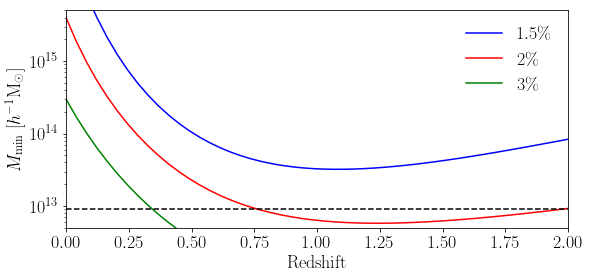

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
colors = ["b", "r", "g"]
for i, accuracy in enumerate(accs):
    ax.plot(zarr, Mmin_all[i], label=labels[i], c=colors[i])
ax.set_yscale("log")
ax.set_ylabel(r"$M_{\rm min}\ [h^{-1}{\rm M}_{\odot}]$")
ax.set_xlabel(r"Redshift")
ax.set_xlim(min(zarr), max(zarr))
ax.set_ylim(5e12, 5e15)
ax.axhline(9e12, c="k", ls='--')
ax.legend(frameon=False)
fig.savefig("minimum_allowed_mass.png", dpi=300, bbox_inches="tight")
fig.savefig("minimum_allowed_mass.pdf", dpi=300, bbox_inches="tight")